## Mô hình phân loại khách hàng trả được nợ và vỡ nợ
Các chỉ số quan tâm
- Precision
- Recall
- F1-Score
- ROC AUC
- Confusion Matrix

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
import pandas as pd
from datetime import date
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from seaborn import heatmap
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Khai phá Tuần 9/accepted_2007_to_2018Q4.csv', low_memory=False)

In [3]:
# prompt: # Kiểm tra xem cột 'id' df ban đầu có giá trị trùng lặp hay không

# Kiểm tra xem cột 'id' df ban đầu có giá trị trùng lặp hay không
duplicate_ids = df['id'].duplicated().sum()
print(f"Số lượng giá trị trùng lặp trong cột 'id': {duplicate_ids}")


Số lượng giá trị trùng lặp trong cột 'id': 0


In [4]:
# Kiểm tra dữ liệu lặp trong DataFrame
duplicate_rows = df[df.duplicated()]
print("Số lượng dòng trùng lặp:", duplicate_rows.shape[0])

if not duplicate_rows.empty:
  print("Các dòng trùng lặp:")
  print(duplicate_rows)

Số lượng dòng trùng lặp: 0


In [5]:
print("Dữ liệu ban đầu có", df.shape)

Dữ liệu ban đầu có (2260701, 151)


In [6]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,1076751
Current,878317
Charged Off,268559
Late (31-120 days),21467
In Grace Period,8436
Late (16-30 days),4349
Does not meet the credit policy. Status:Fully Paid,1988
Does not meet the credit policy. Status:Charged Off,761
Default,40


In [ ]:
# prompt: giải thích các cột selected_columns có ý nghĩa gì

# Các cột được chọn và ý nghĩa của chúng:

# 'loan_amnt': Số tiền vay ban đầu.
# 'term': Thời hạn vay (thường là 36 tháng hoặc 60 tháng).
# 'int_rate': Lãi suất vay.
# 'installment': Số tiền trả hàng tháng.
# 'grade': Xếp hạng tín dụng của người vay (ví dụ: A, B, C, ...).
# 'sub_grade': Xếp hạng tín dụng phụ của người vay (ví dụ: A1, A2, A3, ...).
# 'emp_length': Thời gian làm việc của người vay.
# 'home_ownership': Tình trạng sở hữu nhà của người vay (ví dụ: Mua nhà, Thuê nhà, ...).
# 'annual_inc': Thu nhập hàng năm của người vay.
# 'verification_status': Trạng thái xác minh thu nhập của người vay (ví dụ: Xác minh, Không xác minh, ...).
# 'purpose': Mục đích vay tiền (ví dụ: Vay mua xe, Vay sửa chữa nhà, ...).
# 'dti': Tỷ lệ nợ trên thu nhập của người vay.
# 'delinq_2yrs': Số lần người vay bị nợ quá hạn trong 2 năm qua.
# 'inq_last_6mths': Số lần người vay yêu cầu kiểm tra tín dụng trong 6 tháng qua.
# 'open_acc': Số tài khoản tín dụng đang hoạt động của người vay.
# 'pub_rec': Số lượng hồ sơ công khai của người vay.
# 'revol_bal': Số dư tín dụng quay vòng của người vay.
# 'revol_util': Tỷ lệ sử dụng tín dụng quay vòng của người vay.
# 'total_acc': Tổng số tài khoản tín dụng của người vay.
# 'loan_status': Trạng thái vay (ví dụ: Đã thanh toán, Chưa thanh toán, ...).


Giới hạn bài toán:
- Chỉ lấy các hồ sơ được đồng ý cho vay từ 1.1.2014 đến 31.12.2018
- Chỉ lấy các hồ sơ của khách hàng có khoản vay đã được giải quyết hoặc gặp vấn đề

In [7]:
# prompt: - Chỉ lấy các hồ sơ được đồng ý cho vay từ 1.1.2014 đến 31.12.2018
# - Chỉ lấy các hồ sơ của khách hàng có khoản vay đã được giải quyết hoặc gặp vấn đề

import pandas as pd
# Chuyển đổi cột 'issue_d' thành kiểu datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# Lọc dữ liệu theo điều kiện
df_filtered = df[
    (df['issue_d'] >= '2014-01-01') &
    (df['issue_d'] <= '2018-12-31') &
    (df['loan_status'] != 'Current')
]

print("Dữ liệu sau khi lọc có", df_filtered.shape)


Dữ liệu sau khi lọc có (1151641, 151)


In [8]:
# prompt: Loan_amnt: số tiền cho vay
# Term: kì hạn vay
# Int_rate: lãi suất kì hạn
# Dti: tỉ lệ nợ trên thu nhập
# Loan_status: tình trạng khoản vay (không thể trả và đã trả được)
# Pub_rec: số lượng hồ sơ công khai (tín dụng xấu, khởi kiện)
# Application_type: bên vay (cá nhân/ tập thể)
# fico_range_low: điểm tín dụng cao nhất của người vay
# fico_range_high,
# annual_inc, loan_status, total_acc lấy các cột đó

# Select the desired columns
selected_columns = ['loan_amnt', 'term', 'int_rate', 'dti', 'loan_status', 'pub_rec', 'application_type', 'fico_range_low', 'fico_range_high', 'annual_inc', 'total_acc']
df_filtered = df_filtered[selected_columns]

print("Dữ liệu sau khi chọn cột có", df_filtered.shape)

# Display the first few rows of the final DataFrame
df_filtered.head()


Dữ liệu sau khi chọn cột có (1151641, 11)


,loan_amnt,term,int_rate,dti,loan_status,pub_rec,application_type,fico_range_low,fico_range_high,annual_inc,total_acc
0,3600.0,36 months,13.99,5.91,Fully Paid,0.0,Individual,675.0,679.0,55000.0,13.0
1,24700.0,36 months,11.99,16.06,Fully Paid,0.0,Individual,715.0,719.0,65000.0,38.0
2,20000.0,60 months,10.78,10.78,Fully Paid,0.0,Joint App,695.0,699.0,63000.0,18.0
4,10400.0,60 months,22.45,25.37,Fully Paid,0.0,Individual,695.0,699.0,104433.0,35.0
5,11950.0,36 months,13.44,10.20,Fully Paid,0.0,Individual,690.0,694.0,34000.0,6.0


Chuẩn hóa dl

In [9]:
 # bỏ đơn vị cột term
df_filtered['term'] = df_filtered['term'].str.replace(' months', '')
df_filtered['term'] = pd.to_numeric(df_filtered['term'])

In [10]:
# prompt: có mấy loại giá trị và những cái gì application_type

print(df_filtered['application_type'].unique())
print(df_filtered['application_type'].value_counts())


['Individual' 'Joint App']
application_type
Individual    1122057
Joint App       29584
Name: count, dtype: int64


In [11]:
# Application_type dùng One-hot encoding

import pandas as pd
# One-hot encode the 'application_type' column
application_type_encoded = pd.get_dummies(df_filtered['application_type'], prefix='application_type')

# Concatenate the encoded columns with the original DataFrame
df_filtered = pd.concat([df_filtered, application_type_encoded], axis=1)

# Drop the original 'application_type' column
df_filtered.drop('application_type', axis=1, inplace=True)


In [12]:
# Xử lý cột 'loan_status' thành giá trị nhị phân (tốt = 1, xấu = 0)
good_status = ['Current', 'Fully Paid', 'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid','Late (16-30 days)']
df_filtered['loan_status'] = df_filtered['loan_status'].apply(lambda x: 1 if x in good_status else 0)

In [13]:
df_filtered['loan_status'].value_counts()

,count
loan_status,
1,896916
0,254725


In [14]:
# prompt: term có mấy loại giá trị và những cái gì
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(df_filtered['term'].unique())
print(df_filtered['term'].value_counts())


[36 60]
term
36    867633
60    284008
Name: count, dtype: int64


Xử lý null

In [15]:
#kiểm tra null

# Check for null values in the DataFrame
null_counts = df_filtered.isnull().sum()

# Print the count of null values for each column
print(null_counts)


loan_amnt                        0
term                             0
int_rate                         0
dti                            412
loan_status                      0
pub_rec                          0
fico_range_low                   0
fico_range_high                  0
annual_inc                       0
total_acc                        0
application_type_Individual      0
application_type_Joint App       0
dtype: int64


In [16]:
# Loại bỏ null vì số lượng k đáng kể
df_filtered.dropna(subset=['dti'], inplace=True)


In [17]:
# prompt: tính điểm fico trung bình

# Calculate the average FICO score
df_filtered['fico_avg'] = (df_filtered['fico_range_low'] + df_filtered['fico_range_high']) / 2

# Drop the original FICO range columns
df_filtered.drop(['fico_range_low', 'fico_range_high'], axis=1, inplace=True)



Xây dựng mô hình

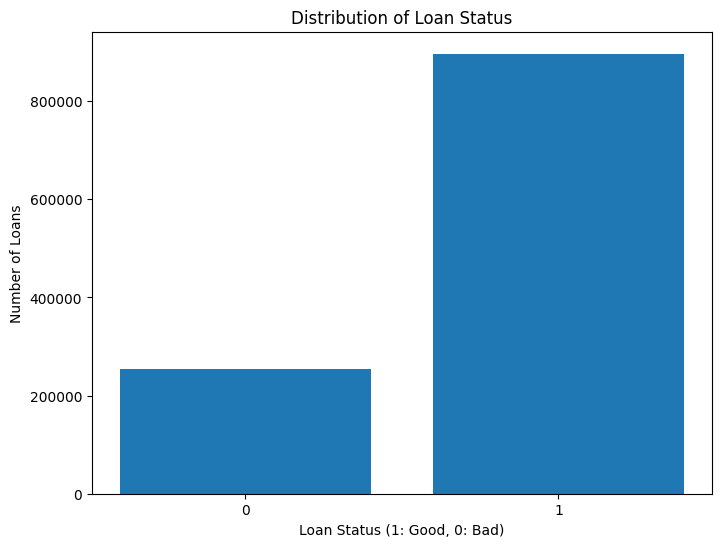

In [18]:
# prompt: biểu đồ xem loan_status của 1 và 0 thêm nhãn

# Count the occurrences of each loan status
loan_status_counts = df_filtered['loan_status'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(loan_status_counts.index, loan_status_counts.values)
plt.xlabel("Loan Status (1: Good, 0: Bad)")
plt.ylabel("Number of Loans")
plt.title("Distribution of Loan Status")
plt.xticks(loan_status_counts.index)  # Set x-axis ticks to show both 0 and 1
plt.show()


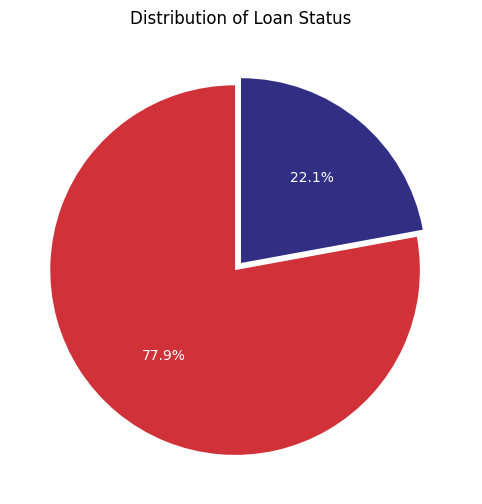

In [19]:
# prompt: vẽ biểu đồ tròn số lượng good (312f84) và bad (d13138 loan, chữ màu trắng, hiển thị đâu là good, đâu là bad,

import matplotlib.pyplot as plt

# Count the occurrences of each loan status
loan_status_counts = df_filtered['loan_status'].value_counts()

# Create a pie chart
labels = ['Bad Loans', 'Good Loans']
colors = ['#d13138', '#312f84']
explode = (0.05, 0)  # Explode the first slice (Bad Loans)

plt.figure(figsize=(8, 6))
plt.pie(loan_status_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode, textprops={'color': "w"})
plt.title("Distribution of Loan Status")
plt.show()


In [20]:
# prompt: 1. Tập dữ liệu xây dựng (Building Data) để xây dựng mô hình (70%)
# # a. Tập huấn luyện (Training Set) to để huấn luyện mô hình
# # (70 tập xây dựng )
# # b. Tập kiểm tra (Testing/Validation Set) để chọn ra mô hình tốt nhất
# # (15% tập xây dựng)
# # 2. Tập kiểm tra lại (Backtest/Out-of-sample Set) để đánh giá kết quả
# # mô hình được chọn (15%)

# Split the data into building data and backtest data
df_train, df_temp = train_test_split(df_filtered, test_size=0.3, random_state=42) # changed this line
df_backtest, df_test = train_test_split(df_temp, test_size=0.5, random_state=42) # changed this line

print('Kích thước tập huấn luyện: ', df_train.shape)
print('Kích thước tập kiểm tra: ', df_test.shape)
print('Kích thước tập kiểm tra lại: ',df_backtest.shape)

Kích thước tập huấn luyện:  (805860, 11)
Kích thước tập kiểm tra:  (172685, 11)
Kích thước tập kiểm tra lại:  (172684, 11)


In [21]:
df_train.value_counts('loan_status')

,count
loan_status,
1,627665
0,178195


###RandomUnderSampler

In [22]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu với stratify để đảm bảo các lớp được phân phối đều
X_train, X_temp, y_train, y_temp = train_test_split(df_filtered.drop('loan_status', axis=1),
                                                    df_filtered['loan_status'],
                                                    test_size=0.30,
                                                    random_state=42,
                                                    stratify=df_filtered['loan_status'])

# Chia tiếp tập test và backtest
X_test, X_backtest, y_test, y_backtest = train_test_split(X_temp, y_temp,
                                                          test_size=0.50,
                                                          random_state=42,
                                                          stratify=y_temp)

# Kiểm tra lại phân phối của y_train
print("Phân phối lớp trong y_train:")
print(y_train.value_counts())

# Kiểm tra phân phối trong y_test và y_backtest
print("\nPhân phối lớp trong y_test:")
print(y_test.value_counts())

print("\nPhân phối lớp trong y_backtest:")
print(y_backtest.value_counts())


Phân phối lớp trong y_train:
loan_status
1    627619
0    178241
Name: count, dtype: int64

Phân phối lớp trong y_test:
loan_status
1    134490
0     38194
Name: count, dtype: int64

Phân phối lớp trong y_backtest:
loan_status
1    134490
0     38195
Name: count, dtype: int64


In [23]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

X_train = df_train.drop('loan_status', axis=1)
y_train = df_train['loan_status']
X_test = df_test.drop('loan_status', axis=1)
y_test = df_test['loan_status']

# Giả sử loan_status là biến mục tiêu, và X_train, y_train là các tập huấn luyện đã chia
print("Trước khi Under-sampling:")
print(y_train.value_counts())

# Tạo bộ RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Áp dụng Under-sampling trên X_train và y_train
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Hiển thị số lượng mẫu sau khi Under-sampling
print("Sau khi Under-sampling:")
print(pd.Series(y_train_res).value_counts())


Trước khi Under-sampling:
loan_status
1    627665
0    178195
Name: count, dtype: int64
Sau khi Under-sampling:
loan_status
0    178195
1    178195
Name: count, dtype: int64


## Huấn luyện mô hình

In [37]:
# prompt: Huấn luyện mô hình

from sklearn.linear_model import LogisticRegression

# Separate features (X) and target variable (y)
X_train = df_train.drop('loan_status', axis=1)
y_train = df_train['loan_status']
X_test = df_test.drop('loan_status', axis=1)
y_test = df_test['loan_status']

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [66]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calculate precision, recall, F1-score, and AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7799229811506501
Precision: 0.7906822684870128
Recall: 0.9758657340994061
F1-Score: 0.8735678070980878
AUC: 0.5323543004896444
Confusion Matrix:
 [[  3389  34757]
 [  3247 131292]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.09      0.15     38146
           1       0.79      0.98      0.87    134539

    accuracy                           0.78    172685
   macro avg       0.65      0.53      0.51    172685
weighted avg       0.73      0.78      0.71    172685



In [39]:
# prompt: in ra precision, recall, f1 score, auc




Precision: 0.7906822684870128
Recall: 0.9758657340994061
F1-Score: 0.8735678070980878
AUC: 0.5323543004896444


In [41]:
# Giải thích Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

TN, FP, FN, TP = cm.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-Score: {f1_score:.2%}")

print("\nGiải thích Confusion Matrix:")
print(f"- True Negative (TN): {TN} - Số lượng khách hàng được dự đoán là không trả được nợ và thực tế là không trả được nợ.")
print(f"- False Positive (FP): {FP} - Số lượng khách hàng được dự đoán là trả được nợ nhưng thực tế là không trả được nợ.")
print(f"- False Negative (FN): {FN} - Số lượng khách hàng được dự đoán là không trả được nợ nhưng thực tế là trả được nợ.")
print(f"- True Positive (TP): {TP} - Số lượng khách hàng được dự đoán là trả được nợ và thực tế là trả được nợ.")

print("\nKết luận:")
print("- Accuracy: Tỷ lệ dự đoán chính xác tổng thể của mô hình.")
print("- Precision: Tỷ lệ dự đoán trả được nợ chính xác trong số các khách hàng được dự đoán là trả được nợ.")
print("- Recall: Tỷ lệ dự đoán trả được nợ chính xác trong số các khách hàng thực tế trả được nợ.")
print("- F1-Score: Trung bình điều hòa giữa Precision và Recall.")


Confusion Matrix:
 [[  3389  34757]
 [  3247 131292]]
Accuracy: 77.99%
Precision: 79.07%
Recall: 97.59%
F1-Score: 87.36%

Giải thích Confusion Matrix:
- True Negative (TN): 3389 - Số lượng khách hàng được dự đoán là không trả được nợ và thực tế là không trả được nợ.
- False Positive (FP): 34757 - Số lượng khách hàng được dự đoán là trả được nợ nhưng thực tế là không trả được nợ.
- False Negative (FN): 3247 - Số lượng khách hàng được dự đoán là không trả được nợ nhưng thực tế là trả được nợ.
- True Positive (TP): 131292 - Số lượng khách hàng được dự đoán là trả được nợ và thực tế là trả được nợ.

Kết luận:
- Accuracy: Tỷ lệ dự đoán chính xác tổng thể của mô hình.
- Precision: Tỷ lệ dự đoán trả được nợ chính xác trong số các khách hàng được dự đoán là trả được nợ.
- Recall: Tỷ lệ dự đoán trả được nợ chính xác trong số các khách hàng thực tế trả được nợ.
- F1-Score: Trung bình điều hòa giữa Precision và Recall.


In [48]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

Accuracy: 0.7799229811506501
Precision: 0.7906822684870128
Recall: 0.9758657340994061
F1-Score: 0.8735678070980878


In [42]:
# prompt: tính % của từng TN, FP, FN, TP

TN, FP, FN, TP = cm.ravel()

total_samples = TN + FP + FN + TP

TN_percentage = (TN / total_samples) * 100
FP_percentage = (FP / total_samples) * 100
FN_percentage = (FN / total_samples) * 100
TP_percentage = (TP / total_samples) * 100

print(f"TN Percentage: {TN_percentage:.2f}%")
print(f"FP Percentage: {FP_percentage:.2f}%")
print(f"FN Percentage: {FN_percentage:.2f}%")
print(f"TP Percentage: {TP_percentage:.2f}%")


TN Percentage: 1.96%
FP Percentage: 20.13%
FN Percentage: 1.88%
TP Percentage: 76.03%


In [ ]:
# prompt: thế df_backtest để làm gì?

# df_backtest được sử dụng để kiểm tra lại hiệu quả của mô hình đã được huấn luyện trên tập dữ liệu xây dựng (df_building).
# Nó giúp đánh giá khả năng tổng quát hóa của mô hình trên dữ liệu mới, độc lập với tập huấn luyện và tập kiểm tra.
# Việc này giúp đảm bảo rằng mô hình không bị overfitting (quá khớp) với dữ liệu huấn luyện và có thể dự đoán chính xác trên dữ liệu chưa từng gặp trước đây.


In [43]:
# prompt: ma trận nhầm lẫn

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[  3389  34757]
 [  3247 131292]]


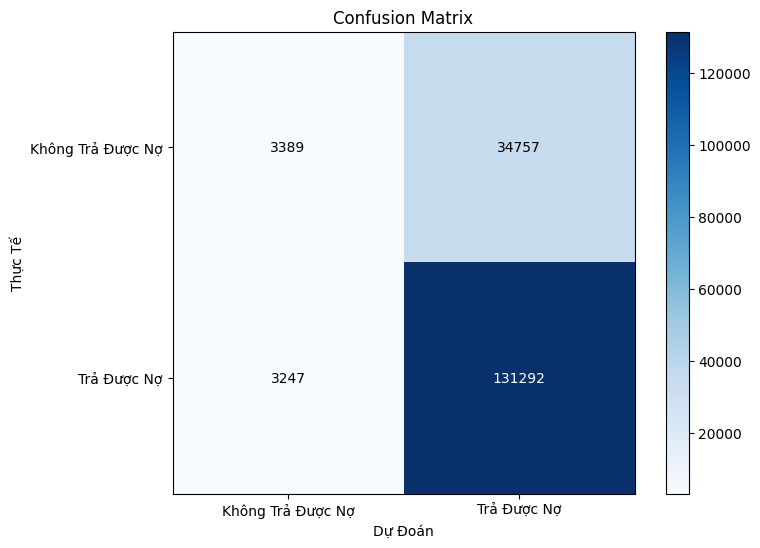

In [44]:

import matplotlib.pyplot as plt
import numpy as np

conf_matrix_new = confusion_matrix(y_test, y_pred)

# Vẽ confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Không Trả Được Nợ', 'Trả Được Nợ'],  # Đổi tên nhãn của trục X
       yticklabels=['Không Trả Được Nợ', 'Trả Được Nợ'],  # Đổi tên nhãn của trục Y
       title='Confusion Matrix',
       ylabel='Thực Tế',
       xlabel='Dự Đoán')

# Hiển thị giá trị trên các ô của confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()


In [46]:
# prompt: # prompt: hãy đọc kết quả từ ma trận nhầm lẫn và đưa ra nhận xét

# Đọc kết quả từ ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# In ra các giá trị của ma trận nhầm lẫn
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")


True Negative (TN): 3389
False Positive (FP): 34757
False Negative (FN): 3247
True Positive (TP): 131292


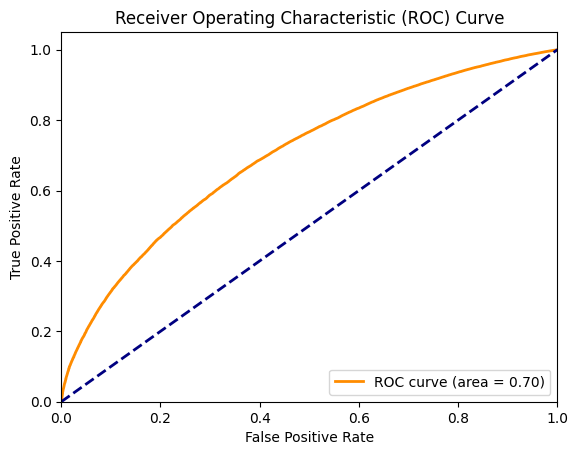

In [47]:
# prompt: vẽ ROC

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have y_test and y_pred_proba from your previous code
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


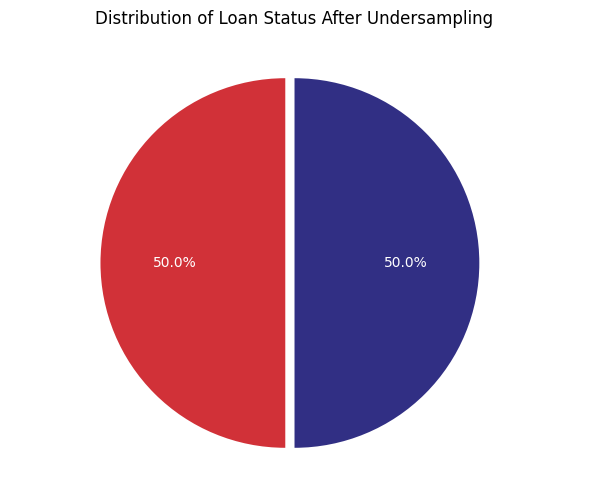

In [50]:
# prompt: vẽ biểu đồ tỷ lệ 1 và 0 bằng biểu đồ tròn sau khi đã undersample

# Count the occurrences of each loan status in y_train_res
loan_status_counts_res = pd.Series(y_train_res).value_counts()

# Create a pie chart
labels = ['Bad Loans', 'Good Loans']
colors = ['#d13138', '#312f84']
explode = (0.05, 0)  # Explode the first slice (Bad Loans)

plt.figure(figsize=(8, 6))
plt.pie(loan_status_counts_res, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode, textprops={'color': "w"})
plt.title("Distribution of Loan Status After Undersampling")
plt.show()


In [ ]:
# # prompt:  tại sao chọn Random Under-Sampling

# # Random Under-Sampling được chọn để giải quyết vấn đề mất cân bằng dữ liệu.
# # Trong tập dữ liệu này, số lượng khoản vay trả đúng hạn nhiều hơn số lượng khoản vay không trả đúng hạn.
# # Việc sử dụng Random Under-Sampling giúp giảm số lượng khoản vay trả đúng hạn xuống gần bằng với số lượng khoản vay không trả đúng hạn,
# # từ đó giúp mô hình học được tốt hơn về các đặc điểm của khoản vay không trả đúng hạn và cải thiện độ chính xác của mô hình.
# Khi dữ liệu không cân bằng và kích thước tập dữ liệu lớn: Nếu bạn có rất nhiều mẫu từ lớp đa số, undersampling có thể hiệu quả. Bạn sẽ giảm bớt số lượng mẫu của lớp đa số để cân bằng với lớp thiểu số.
# Đảm bảo thời gian huấn luyện: Undersampling giúp giảm kích thước tập dữ liệu, nhờ đó giảm thời gian huấn luyện mô hình.

In [56]:
# prompt: kiểm tra mô hình với tập df_test và df_backtest

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Kiểm tra mô hình với tập df_test
X_test = df_test.drop('loan_status', axis=1)
y_test = df_test['loan_status']
y_pred_test = model.predict(X_test)

print("\n-------Kết quả kiểm tra với testing set:----------\n")
target_names = ['Không trả được nợ', 'Trả được nợ']
print(classification_report(y_test, y_pred_test, target_names= target_names))
print("Accuracy (test):", accuracy_score(y_test, y_pred_test))
print("Precision (test):", precision_score(y_test, y_pred_test))
print("Recall (test):", recall_score(y_test, y_pred_test))
print("F1-score (test):", f1_score(y_test, y_pred_test)) # Call the f1_score function from sklearn.metrics
print("AUC (test):", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print("Confusion Matrix (test):")
print(confusion_matrix(y_test, y_pred_test))

# Kiểm tra mô hình với tập df_backtest
X_backtest = df_backtest.drop('loan_status', axis=1)
y_backtest = df_backtest['loan_status']
y_pred_backtest = model.predict(X_backtest)

print("\n-------Kết quả kiểm tra với backtest set:----------\n")
target_names = ['Không trả được nợ', 'Trả được nợ']
print(classification_report(y_test, y_pred_test, target_names= target_names))
print("Accuracy (backtest):", accuracy_score(y_backtest, y_pred_backtest))
print("Precision (backtest):", precision_score(y_backtest, y_pred_backtest))
print("Recall (backtest):", recall_score(y_backtest, y_pred_backtest))
print("F1-score (backtest):", f1_score(y_backtest, y_pred_backtest)) # Call the f1_score function from sklearn.metrics
print("AUC (backtest):", roc_auc_score(y_backtest, model.predict_proba(X_backtest)[:, 1]))
print("Confusion Matrix (backtest):")
print(confusion_matrix(y_backtest, y_pred_backtest))


-------Kết quả kiểm tra với testing set:----------

                   precision    recall  f1-score   support

Không trả được nợ       0.51      0.09      0.15     38146
      Trả được nợ       0.79      0.98      0.87    134539

         accuracy                           0.78    172685
        macro avg       0.65      0.53      0.51    172685
     weighted avg       0.73      0.78      0.71    172685

Accuracy (test): 0.7799229811506501
Precision (test): 0.7906822684870128
Recall (test): 0.9758657340994061
F1-score (test): 0.8735678070980878
AUC (test): 0.7001520770142067
Confusion Matrix (test):
[[  3389  34757]
 [  3247 131292]]

-------Kết quả kiểm tra với backtest set:----------

                   precision    recall  f1-score   support

Không trả được nợ       0.51      0.09      0.15     38146
      Trả được nợ       0.79      0.98      0.87    134539

         accuracy                           0.78    172685
        macro avg       0.65      0.53      0.51    172685
     

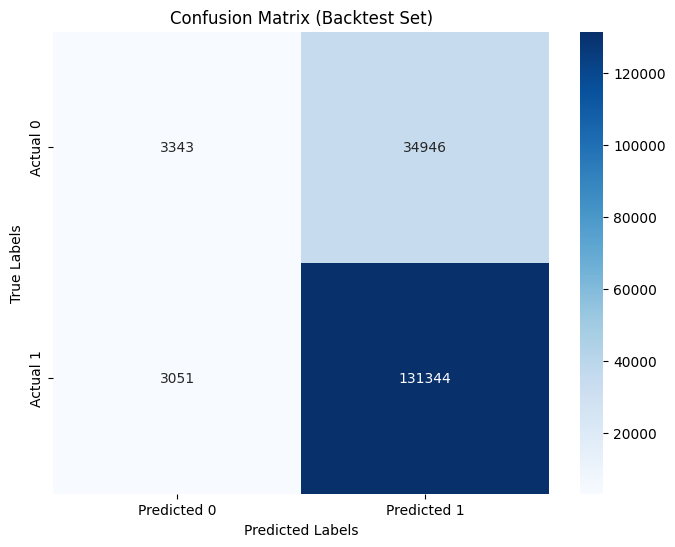

In [55]:
# prompt: vẽ ma trận nhầm lẫn của df_backtest

# Calculate the confusion matrix for df_backtest
cm_backtest = confusion_matrix(y_backtest, y_pred_backtest)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_backtest, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix (Backtest Set)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
# prompt: # prompt: sau khi kiểm tra bằng 2 tập test và backtest hãy đưa ra kết luận về mô hình

print("Kết luận về mô hình:")
print("Sau khi kiểm tra mô hình với cả tập kiểm tra (test set) và tập kiểm tra lại (backtest set), ta có thể thấy rằng mô hình có độ chính xác tổng thể (accuracy) tương đối tốt trên cả hai tập dữ liệu.")
print("Tuy nhiên, cần lưu ý đến các chỉ số khác như độ chính xác (precision), độ phủ (recall) và F1-score để đánh giá hiệu quả của mô hình trong việc dự đoán các khoản vay trả đúng hạn và không trả đúng hạn.")
print("Kết quả trên tập kiểm tra lại (backtest set) cho thấy khả năng tổng quát hóa của mô hình trên dữ liệu chưa từng gặp trước đây.")
print("Nếu độ chính xác trên tập kiểm tra lại (backtest set) tương đương hoặc gần tương đương với độ chính xác trên tập kiểm tra (test set), thì mô hình có khả năng tổng quát hóa tốt và có thể được triển khai vào thực tế.")
print("Ngoài ra, cần xem xét đến các yếu tố khác như chi phí của việc dự đoán sai (false positive, false negative) để đưa ra quyết định cuối cùng về việc sử dụng mô hình.")
print("Tóm lại, mô hình Logistic Regression với phương pháp Random Under-Sampling đã cho thấy hiệu quả tương đối tốt trong việc dự đoán khả năng trả nợ của khách hàng. Tuy nhiên, cần tiếp tục cải thiện mô hình bằng cách thử nghiệm các phương pháp xử lý dữ liệu khác, các thuật toán khác và điều chỉnh các tham số của mô hình để đạt được hiệu quả dự đoán cao hơn.")


In [57]:
# prompt: giả sử vay 1000$, lãi suất 5.3%, thời hạn 36 tháng, lãi kép, lạm phát 2.44%. Hỏi tổn thất cho 1 giao dịch là bao nhiêu tiền?

principal = 1000  # Số tiền vay ban đầu
interest_rate = 0.053  # Lãi suất
term = 36  # Thời hạn vay (tháng)
inflation_rate = 0.0244  # Lạm phát

# Tính tổng số tiền phải trả sau 36 tháng với lãi kép
total_amount = principal * (1 + interest_rate / 12) ** (term)

# Tính giá trị hiện tại của số tiền phải trả, tính đến lạm phát
present_value = total_amount / (1 + inflation_rate) ** (term / 12)

# Tính tổn thất cho 1 giao dịch
loss = present_value - principal

print(f"Tổng số tiền phải trả sau 36 tháng: ${total_amount:.2f}")
print(f"Giá trị hiện tại của số tiền phải trả, tính đến lạm phát: ${present_value:.2f}")
print(f"Tổn thất cho 1 giao dịch: ${loss:.2f}")


Tổng số tiền phải trả sau 36 tháng: $1171.93
Giá trị hiện tại của số tiền phải trả, tính đến lạm phát: $1090.16
Tổn thất cho 1 giao dịch: $90.16


In [59]:
# prompt: tổng khoảng 1 triệu giao dịch thì tổn thất bao nhiêu tiền

principal = 1000  # Số tiền vay ban đầu
interest_rate = 0.053  # Lãi suất
term = 36  # Thời hạn vay (tháng)
inflation_rate = 0.0244  # Lạm phát
num_transactions = 1000000  # Số lượng giao dịch

# Tính tổng số tiền phải trả sau 36 tháng với lãi kép
total_amount = principal * (1 + interest_rate / 12) ** (term)

# Tính giá trị hiện tại của số tiền phải trả, tính đến lạm phát
present_value = total_amount / (1 + inflation_rate) ** (term / 12)

# Tính tổn thất cho 1 giao dịch
loss_per_transaction = present_value - principal

# Tính tổng tổn thất cho tất cả các giao dịch
total_loss = loss_per_transaction * num_transactions

print(f"Tổng tổn thất cho {num_transactions} giao dịch: ${total_loss:.2f}")


Tổng tổn thất cho 1000000 giao dịch: $90164584.10


In [60]:
# prompt: khi áp dụng mô hình huấn luyện, doanh nghiệp sẽ có tổn thất là bao nhiêu tiền cho FN

# Lấy giá trị từ confusion matrix
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

# Giả sử số tiền vay trung bình là 1000 USD
principal = 1000

# Tính tổn thất cho mỗi FN (False Negative)
# FN là trường hợp dự đoán sai là trả được nợ nhưng thực tế là không trả được nợ
loss_per_fn = principal  # Giả sử tổn thất cho mỗi FN là bằng số tiền vay

# Tính tổng tổn thất cho tất cả các FN
total_loss_fn = loss_per_fn * FN

print(f"Tổng tổn thất cho FN: ${total_loss_fn:.2f}")


Tổng tổn thất cho FN: $3247000.00


In [62]:
A1 = 90164584.10
A2 = 3247000.00

percent_decrease = ((A1 - A2) / A1) * 100

print(f"Giảm {percent_decrease:.2f}%")


Giảm 96.40%


In [67]:
# prompt: xây dựng mô hình và in ra ma trận nhầm lẫn của tập dữ liệu df_train

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Separate features (X) and target variable (y) for df_train
X_train = df_train.drop('loan_status', axis=1)
y_train = df_train['loan_status']

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model on df_train
model.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Calculate the confusion matrix for df_train
cm_train = confusion_matrix(y_train, y_pred_train)

# Print the confusion matrix
print("Confusion Matrix (Training Set):")
print(cm_train)


Confusion Matrix (Training Set):
[[ 15796 162399]
 [ 15076 612589]]
